# Pydata Okinawa #32
### Edwardで確率的プログラミング

コイン投げモデルを変分近似してみる編

## やること
- "コイン投げ" の確率モデル（Beta-Bernoulliモデル）をEdwardで実装する
- 構築されたモデルと観測データをもとに、変分推定で変分分布パラメータを真の分布に近似する

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from ipywidgets import interact

import numpy as np
import tensorflow as tf
import edward as ed
# ベータ分布とベルヌーイ分布をedwardから読み込む
from edward.models import Beta, Bernoulli

In [2]:
ed.set_seed(42)

In [3]:
# 観測データが無い場合
#x_data = np.array([])

# 0ばかり観測された場合
# x_data = np.array([0] * 10)
x_data = np.array([0] * 50)

# 0と1が確率的に観測された場合
# n_data = 50
# np.random.seed(0)
# x_data = (np.random.rand(n_data) < 0.5).astype('int')

# コインを振った回数
N = len(x_data)

print("Number of tirals:\t%d" % N)
print("Observed data:\t", x_data)
if len(x_data) > 0:
    print("Mean value:\t%.3f" % x_data.mean())

Number of tirals:	50
Observed data:	 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
Mean value:	0.000


# コイン投げ Model を定義
<img src="beta_bernoulli_model_w_inference_distribution.png", dpi=30>

In [4]:
# Beta-Bernoulliモデルを構築

# concentration1 = 1.0
# concentration0 = 1.0

concentration1 = 3.0
concentration0 = 2.0

# コイン投げモデルを定義してみましょう。 上図がヒントです。
p_mu = Beta(float(concentration1), float(concentration0), name='p_mu')
x = Bernoulli(tf.ones(N) * p_mu, name='x')

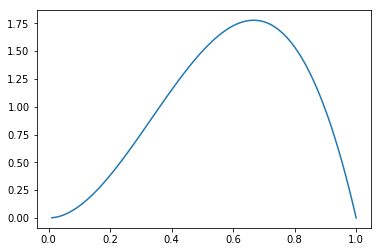

In [5]:
# 定義したBeta分布を定義してみる(事前分布)
sess = ed.get_session()
xs = np.linspace(0.01, 1.0, 100, dtype=np.float32)
pdf = p_mu.prob(xs).eval()
plt.plot(xs, pdf)
plt.show()
sess.close()

# 変分近似で$q_{\mu}$のパラメータを推論する

In [6]:
# 変分分布を定義, 変分近似で推論の為に操作されるパラメータには tf.Variable を付けること
q_mu_a = tf.nn.softplus(tf.Variable(0.0), name='q_mu_a')
q_mu_b = tf.nn.softplus(tf.Variable(0.0), name='q_mu_b')
q_mu = Beta(q_mu_a, q_mu_b, name='vi_q_mu')

In [7]:
inference = ed.KLqp({p_mu: q_mu}, data={x: x_data})

逐次的に推論を実行する

In [8]:
# optimizerを設定
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)

# 推論時のパラメータを設定
inference.initialize(
    optimizer=optimizer, 
    n_samples=5, # 推論時に1イテレーションで使用するサンプル数
    n_iter=6000, #最大イテレーション数
    n_print=100) # 100回ごとにログを書き出す

histories = {'t': [], 'loss': []}
i_iters = []

# 100回ごとに推論するqのパラメータを保存
q_mus = []
q_means = []

mu_domain = np.linspace(0.01, 1.0, 100, dtype=np.float32)

In [9]:
# 推論開始
sess = ed.get_session()
tf.global_variables_initializer().run()

for i_iter in range(inference.n_iter):
    
    if i_iter % 100 == 0:
        i_iters.append(i_iter)
        curr_q_mu = q_mu.prob(mu_domain).eval()
        q_mus.append(curr_q_mu)
        q_means.append(q_mu.mean().eval())
    
    info_dict = inference.update()
    inference.print_progress(info_dict)
    
    histories['t'].append(info_dict['t'])
    histories['loss'].append(info_dict['loss'])

inference.finalize()

6000/6000 [100%] ██████████████████████████████ Elapsed: 25s | Loss: 40.800


学習のログを確認する

In [10]:
# 100イテレーション毎のベータ分布の確率密度関数をプロットする
# 黒い線が今のイテレーション毎に変化する

num_evaluations = len(q_mus)

@interact(i=(0, num_evaluations - 1, 1))
def plot_q_mu(i=0):
    fig, ax = plt.subplots(1, 1)

    for j in range(num_evaluations):
        color = cm.jet(j / num_evaluations)
        ax.plot(mu_domain, q_mus[j], color=color, alpha=0.2)
    
    ax.plot(mu_domain, q_mus[i], 'k')
    ax.set_ylim([0, 6])
    ax.set_title('Iteration: %d, q_mean: %.2f' % (i_iters[i], q_means[i]))
    plt.show()

観測データを反映したモデルになっているだろうか。

lossの確認

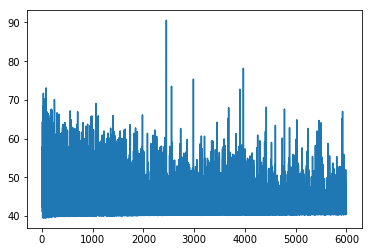

In [11]:
plt.plot(histories['t'], histories['loss'])

推定したベータ分布のパラメータを確認する

In [12]:
message = "q_mu_a: {}\nq_mu_b: {} \nq_mu mean: {}".format(
    q_mu_a.eval(), q_mu_b.eval(), q_mu.mean().eval())
print(message)

q_mu_a: 0.5982202887535095
q_mu_b: 3.2388691902160645 
q_mu mean: 0.15590469539165497
